# Cleaning und Spellchecking

Autor: Christian Koss - ckoss@uni-bremen.de

In [1]:
import sqlite3
import re
import pandas as pd
import Levenshtein
amazon_sql = 'data/amazon/amazon.db'
text_processing_sql= 'data/text_processing/text_processing.db'

# 1. Erstelle text_processing.db

In [3]:
conn = sqlite3.connect(amazon_sql)
cur = conn.cursor() 

cur.execute('SELECT ID, text FROM dvd') 
dataframe=pd.DataFrame([(ID,text) for ID, text in cur], columns=list(map(lambda x: x[0], cur.description)))
conn.close()

####################

db='raw' 
conn = sqlite3.connect(text_processing_sql)
cur = conn.cursor()                                 

wildcards = ','.join(['?'] * len(dataframe.columns))              

cur.execute("drop table if exists %s" % db)

col_str = '"' + '","'.join(dataframe.columns) + '"'
cur.execute("create table %s (%s)" % (db, col_str))

cur.executemany("insert into %s values(%s)" % (db, wildcards), [tuple(x) for x in dataframe.values])

conn.commit()
conn.close()


# 2. Cleaning

In [2]:
conn = sqlite3.connect(amazon_sql)
cur = conn.cursor() 

cur.execute('SELECT ID, text FROM dvd') 
tokenset={}
origin={}
links=[]
code=[]
empty=0

for ID, text in cur:
    if text is not None:
        try:
            code+=re.findall('<.*?>',text)
        except:
            pass
        try:
            links+=re.findall('http[\s]{0}[^\s]+|http:\/\/ [^\s]+|www[.][^\s]+',text)
        except:
            pass
        
        text=re.sub('<.*?>','',text)
        text=re.sub('http[^\s]+|http:\/\/ [^\s]+|www[.][^\s]+','',text)
        tokens=[word.strip('-') for word in re.findall("""[^\s]+""", text)]
        
        if len(tokens)>0:       
            for word in tokens:
                try:
                    tokenset[word]+=1
                except:
                    tokenset[word]=1 
                    origin[word]=str(ID)
        else:
            empty+=1
    else:
        empty+=1
                    
conn.close()
tokenset.pop('', None)
origin.pop('', None)
print('Tokens: ', len(tokenset))
print('Gelöschte Links: ', len(links))
print('Gelöschter Code: ', len(code))
print('Leere Reviews: ', empty)

Tokens:  639097
Gelöschte Links:  175
Gelöschter Code:  0
Leere Reviews:  10


# Analysiere unbekannte Zeichen

In [3]:
temp=''.join([token for token,count in tokenset.items()])
htmlcode=set(re.findall('&[^&;]+;',temp))
print('htmlcode: ',htmlcode)

temp=''.join(list(set(temp)))
print('verschiedene Zeichen: ',len(temp))

chars=re.sub('[A-Za-z0-9\-\\\/\{\[\]}\(\)äöüßÄÖÜ.!?,;\"\':]', '', temp)
print('unbekannte Zeichen: ',len(chars))

char_dict={}
for token, count in tokenset.items():
    for char in chars:
        if char in token:
            try:
                char_dict[char]+=[token]
            except:
                char_dict[char]=[token]
                
for char, tokens in char_dict.items():
    print(char,'\t', ' '.join(tokens[:8]))

htmlcode:  {'&amp;', '&lt;', '&gt;'}
verschiedene Zeichen:  178
unbekannte Zeichen:  92
Î 	 Îch
ú 	 Andúril, Manjúshri). Zuschaúer dejavú Kahlúa Haúse drúmrum Wanús
ë 	 Athanaël Brontës, Zoë Noël Brontë Brontë. Saint-Saëns (Chloë
 	 Hoffentlich Das Star Fight Stromberg". Wem Muxmäuschenstill" Handarbeit".
· 	 ·
# 	 #7 #010 #5 #4 NOW# #3 #011 #1"
° 	 451° 360° 276,6° ****° WIRKUNG!°! C°. °C) ***°°
Å 	 ("LÅT Åkerlund
û 	 Kaijû-Film Gewöhnungsbedûrftig thrakatulûk, durbatulûk, Mûmakil Nazgûl) Hautgoût. Nazgûl,
% 	 78%, 100%-tiger 0,00% 69% Film100% 80-90% 0,058%. 70%
’ 	 Smith’, gesteh’s, Dante’s you’re gab’s hab’s ("Dante’s „I’m
ò 	 Senòr Kròl Castelcutò Villazòn Fantaghirò, Misiòn Cuaròn
Û 	 UCHÛ
Š 	 lŠsst. Šerbedžija,
í 	 íst.Am Regísseur Gríma Kínder Siríus zwíschendurch Oríginal nícht
β 	 ausschlieβlich daβ Auβerdem auschlieβlich
È 	 MÈRE OouuumÈÈÈÈgaaaahh"
Ú 	 Únd
ï 	 zoïle" (Maïwenn zoïle DïArcy naïven Paï naïve Zaïna
– 	 –
“ 	 „Werk“ „Hotel“ „Lolita“ Live“ Kandidat“, sah“

# Handling unbekannter Zeichen & cleane Korpus

In [64]:
def char_replace(String):
    Sub=[('A','ÀÁÂÃÅ'),('Ae','Æ'),('E','ÈÉÊ'),('I','ÌÍÎÏ'),('O','ÓØÚ'),('U','ÚÛ'),
             ('a','àáâãå'),('ae','æ'),('c','ç'),('e','èéêë'),('i','ìíîï'),('n','ñ'),
             ('o','òóôø'),('o','òóôø'),('u','ùúû'),('u','ùúû'),('Oe','Œ'),('oe','œ'),
             ('S','Š'),('s','š'),('Y','Ÿ'),('Z','Ž'),('z','ž'),('ß','β'),('...','…'),
             ("""'""",'`'),("""'""",'’'),("""'""",'´')]
    for new,old in Sub:
        String=re.sub('['+old+']',new, String)

    Replace=[('&amp;',' und '),('&lt;',''), ('&gt;',''),('&',' und '),
             ('\xad',''),('\x84',''),('\x9c','Ü'),('\x9f','ß'),('\xc3\xb6','ö'),('\xc3\xbc','ü'),('\xc3\xa4','ä'),
             ('A¤','ä'),('A¶','ö'),('A¼','ü'),('~',''),('=',' '),('_',' '),
             ('|',' '),('*',' '),('+',' '),('¬',''),('²',''),('³',''),('au§er','außer'),('Spa§','Spaß')]

    for old,new in Replace:
        String=String.replace(old,new)
        
    String=re.sub('[#$%&@^_¡£§©«®°¶·»¼½–—‘‚“”„€]','', String)

    #Standard
    String=re.sub('[,;]', ' ', String)
    String=re.sub('[.!?,;]', ' . ', String).replace('-',' ')
    String=re.sub('[0-9\\\/\{\[\]}\(\)\"\'\:]', ' ', String)
    String=re.sub('\s+',' ', String).strip()
    return String

In [100]:
#Cleaning
conn = sqlite3.connect(text_processing_sql)
cur = conn.cursor() 

cur.execute('SELECT ID, text FROM raw') 
tokenset={}
origin={}
links=[]
code=[]
empty=0
data=[]

for ID, text in cur:
    if text is not None:
        try:
            code+=re.findall('<.*?>',text)
        except:
            pass
        try:
            links+=re.findall('http[\s]{0}[^\s]+|http:\/\/ [^\s]+|www[.][^\s]+',text)
        except:
            pass
        
        text=re.sub('<.*?>','',text)
        text=re.sub('http[^\s]+|http:\/\/ [^\s]+|www[.][^\s]+','',text)
        text=char_replace(text)
        text=re.sub('[.\s]+[.][.\s]+','.',text).replace('.',' . ')
        tokens=[word.strip('-').strip() for word in re.findall("""[^\s]+""", text)]
        
        data.append((ID,' '.join(tokens)))
        
        if len(tokens)>0:       
            for word in tokens:
                try:
                    tokenset[word]+=1
                except:
                    tokenset[word]=1 
                    origin[word]=str(ID)
        else:
            empty+=1
    else:
        empty+=1
                    
conn.close()
tokenset.pop('', None)
origin.pop('', None)
print('Tokens: ', len(tokenset))
print('Gelöschte Links: ', len(links))
print('Gelöschter Code: ', len(code))
print('Leere Reviews: ', empty)

temp=''.join([token for token,count in tokenset.items()])
htmlcode=set(re.findall('&[^&;]+;',temp))
print('htmlcode: ',htmlcode)

temp=''.join(list(set(temp)))
print('verschiedene Zeichen: ',len(temp))

chars=re.sub('[A-Za-zäöüßÄÖÜ0-9.]', '', temp)
print('unbekannte Zeichen: ',len(chars))

Tokens:  306887
Gelöschte Links:  175
Gelöschter Code:  0
Leere Reviews:  12
htmlcode:  set()
verschiedene Zeichen:  60
unbekannte Zeichen:  0


In [105]:
# save clean
dataframe=pd.DataFrame(data, columns=['ID','text'])
db='clean' 
conn = sqlite3.connect(text_processing_sql)
cur = conn.cursor()                                 

wildcards = ','.join(['?'] * len(dataframe.columns))              

cur.execute("drop table if exists %s" % db)

col_str = '"' + '","'.join(dataframe.columns) + '"'
cur.execute("create table %s (%s)" % (db, col_str))

cur.executemany("insert into %s values(%s)" % (db, wildcards), [tuple(x) for x in dataframe.values])

conn.commit()
conn.close()

# Cleaning Ende

In [6]:
#Finde Wörter mit Buchstaben und Zahlen
wortUzahl=[]
for token,count in tokenset.items():
    l0=len(token)
    temp=re.sub('[A-Za-zäöüßÄÖÜ]', '', token)
    l1=len(temp)
    l2=len(re.sub('[0-9]', '', temp))
    if l0>l1 and l1>l2:
        wortUzahl.append(token)
print(len(set(wortUzahl)),'Mischwörter:', ' '.join(wortUzahl[:20]), '...')

0 Mischwörter:  ...


In [7]:
#absolute Häufigkeit der Token
absolutP=sorted([(v,k) for k,v in tokenset.items()], reverse=True)
counter={k:v for v,k in absolutP}


len(counter),absolutP[:30]

(306887,
 [(1676275, '.'),
  (332182, 'und'),
  (311909, 'die'),
  (273924, 'der'),
  (197524, 'ist'),
  (141949, 'nicht'),
  (140758, 'in'),
  (133773, 'Film'),
  (127979, 'zu'),
  (125849, 'den'),
  (118859, 'das'),
  (107551, 'ich'),
  (96049, 'mit'),
  (94922, 'ein'),
  (94156, 'von'),
  (93269, 'sich'),
  (92244, 'auch'),
  (85963, 'es'),
  (83960, 'auf'),
  (82682, 'man'),
  (71637, 'eine'),
  (65013, 'Die'),
  (64155, 'aber'),
  (63085, 'als'),
  (62585, 'für'),
  (61661, 'nur'),
  (59789, 'dem'),
  (58537, 'so'),
  (58348, 'hat'),
  (57079, 'wie')])

In [8]:
# Lade Wiktionary
wiktionary_sql = 'data/wiktionary/wiktionary.db'
conn=sqlite3.connect(wiktionary_sql)
cur = conn.cursor()
cur.execute('SELECT token, quick_stemm, quick_pos FROM lexikon')
stemm_pos={token:(quick_stemm, quick_pos) for token, quick_stemm, quick_pos in cur}
stemm_pos_low={token.lower():value for token, value in stemm_pos.items()}
conn.close() 

#test
stemm_pos['geladen']

('laden', 'Verb')

In [10]:
tagged={}
untagged=[]
counter_stemm={}
#form={}
for tok in counter.keys():
    tok1=tok.lower()
    tok2=tok1.title()
    
    try:   
        stemm=stemm_pos_low[tok1]
        tagged[tok]='None'
    except:
        untagged.append(tok)
"""
    pos=False    
    if tok1 in stemm_pos.keys():     
        stemm=stemm_pos[tok1]
        pos=True
    elif tok2 in stemm_pos.keys():
        stemm=stemm_pos[tok2]
        pos=True
    else:
        untagged.append(tok)
   
    if pos==True:
        if stemm in tagged:
            tagged[stemm]+=int(counter[tok])
        else:
            tagged[stemm]=int(counter[tok])
            
        if stemm in form and tok not in form[stemm].split('|'):
            form[stemm]+='|'+tok
        else:
            form[stemm]=tok
"""    
len(tagged), len(untagged)

(120303, 186584)

In [13]:
# Lade NER
wiktionary_sql = 'data/data.db'
conn=sqlite3.connect(wiktionary_sql)
cur = conn.cursor()
cur.execute('SELECT token, pos FROM ner2')
stemm_pos2={token:pos for token, pos in cur}
stemm_pos_low2={token.lower():pos for token, pos in stemm_pos2.items()}
conn.close() 

#test
stemm_pos2['Hephaistos']

'figur'

# Spellcheck Start

In [106]:
templ1={k:k for k,v in stemm_pos_low.items() if len(k)>3}
templ2={k:k for k,v in stemm_pos_low2.items() if len(k)>3}
print(len(templ1))
templ1.update(templ2)
print(len(templ1))

560083
695104


In [150]:
untagged3=[]
match={}

#lexik={k:k for k,v in stemm_pos_low.items() if len(k)>3}
lexik={k:k for k,v in templ1.items() if len(k)>3}
#lexik.update(stemm_pos_low)
lexik_lw=sorted([(len(w),w) for w in lexik if len(w)>2 and ' ' not in w], reverse=True)

c=0

count=len(untagged)
print(count)
for bad_word in untagged:
    count=count-1
    save_word=bad_word
    bad_word=bad_word.lower()
    temp1=bad_word.replace('ae','ä').replace('oe','ö').replace('ue','ü')
    temp2=temp1.replace('ss','ß')
    temp3=bad_word.replace('rumzu','')
    if bad_word[-3:]=='dem' or bad_word[-3:]=='der' or bad_word[-3:]=='den':
        temp4=bad_word[:-3]
    else:
        temp4=bad_word
    temp5=bad_word.replace('f','v')
    if bad_word[-2:]=='er':
        temp6=bad_word[:-2]
    else:
        temp6=bad_word
    temp7=bad_word.replace('c','k')
    if bad_word[:2]=='ab' or bad_word[:2]=='ge' or bad_word[:2]=='zu':
        temp8=bad_word[2:]
    elif bad_word[:3]=='aus' or bad_word[:3]=='auf' or bad_word[:3]=='mit':
        temp8=bad_word[3:]
    else:
        temp8=bad_word

    
    if bad_word in lexik:
        match[save_word]=lexik[bad_word]
        continue
        
    if temp1 in lexik:
        match[save_word]=lexik[temp1]
        continue
        
    if temp2 in lexik:
        match[save_word]=lexik[temp2]
        continue
        
    if temp3 in lexik:
        match[save_word]=lexik[temp3]
        continue
    
    if temp5 in lexik:
        match[save_word]=lexik[temp5]
        continue
    
    if len(temp)>5 and temp4 in lexik:
        match[save_word]=lexik[temp4]
        continue
        
    if len(temp)>5 and temp6 in lexik:
        match[save_word]=lexik[temp6]
        continue
    
    if temp7 in lexik:
        match[save_word]=lexik[temp7]
        continue
        
    if len(bad_word)>8 and bad_word[:-2] in lexik:
        match[save_word]=lexik[bad_word[:-2]]
        continue
        
    if len(bad_word)>6 and bad_word[:-1] in lexik:
        match[save_word]=lexik[bad_word[:-1]]
        continue
        
    if bad_word[:2]=='un' and bad_word[2:] in lexik:
        match[save_word]='nicht'+' '+lexik[bad_word[2:]]
        continue
        
    if len(bad_word)>6 and bad_word[-4:]=='chen' and not 'schen' in bad_word and bad_word.replace('chen','') in lexik:
        match[save_word]=lexik[bad_word.replace('chen','')]
        if temp in lexik:
            match[save_word]=lexik[temp]
            continue
        elif temp.replace('ä','a').replace('ö','o').replace('ü','u') in lexik:
            match[save_word]=lexik[temp.replace('ä','a').replace('ö','o').replace('ü','u')]
            continue
    
    
    if len(bad_word)>8:
        for i in range(4,len(bad_word)):
            head=bad_word[:i]
            tail=bad_word[i:]
            if head in lexik and tail in lexik:
                match[save_word]=(head+' '+tail)
                #print(bad_word,head,tail)
                continue
    
    if len(bad_word)>8:
        for i in range(3,len(bad_word)):
            head=bad_word[:i]
            tail=bad_word[i:]
            if head in lexik and tail in lexik:
                match[save_word]=(head+' '+tail)
                break;
        try:
            match[save_word]
            continue
        except:
            pass

    if len(bad_word)>7:
        for i in range(3,len(bad_word)):
            head=bad_word[:i]
            tail=bad_word[i:]
            if head in lexik and tail in lexik:
                match[save_word]=(head+' '+tail)
                #print(bad_word,head,tail)
                break;
        try:
            match[save_word]
            continue
        except:
            pass
        
    if len(bad_word)>7:
        for i in range(3,len(temp4)):
            head=temp4[:i]
            tail=temp4[i:]
            if head in lexik and tail in lexik:
                match[save_word]=(head+' '+tail)
                #print(bad_word,head,tail)
                break;
        try:
            match[save_word]
            continue
        except:
            pass
                
    if len(bad_word)>10:
        for i in range(3,len(bad_word)-3):
            head=bad_word[:i]
            for j in range(i+3,len(bad_word)-3):
                middle=bad_word[i:j]
                tail=bad_word[j:]
                if head in lexik and middle in lexik and tail in lexik:
                    match[save_word]=(head+' '+middle+' '+tail)
                    #print(bad_word,head,middle,tail)    
        try:
            match[save_word]
            continue
        except:
            pass
        
        
    if len(temp2)>8:
        for i in range(4,len(temp2)):
            head=temp2[:i]
            tail=temp2[i:]
            if head in lexik and tail in lexik:
                match[save_word]=(head+' '+tail)
                #print(bad_word,head,tail)
        try:
            match[save_word]
            continue
        except:
            pass
                
                
    if len(temp8)>4 and temp8 in lexik:
        match[save_word]=lexik[temp8]
        continue
    
   # loop=[w for l,w in lexik_lw if w[0]==bad_word[0]]
   # for temp in loop:
   #     if Levenshtein.ratio(temp,bad_word)>0.95:
   #             match[save_word]=temp
   #             print(save_word,temp)
    try:
        match[save_word]
        continue
    except:
        pass
   #if bad_word=='urlaubsort':
   #     break;
            
            
     
   
    try:
        match[save_word]
    except:
        untagged3.append(save_word)
                    
    #if count%1000==0:
    #    print(count)
len(match), len(untagged3)

186584


(122719, 63865)

In [151]:
match['unvermeintlichen']

'nicht vermeintlichen'

In [152]:
data=[]
#load clean
conn = sqlite3.connect(text_processing_sql)
cur = conn.cursor() 

cur.execute('SELECT ID, text FROM clean') 

def spell(String, dic):
    try:
        return dic[String]
    except:
        return String
    
for ID, text in cur:
    tokens=text.split(' ')
    tokens=[spell(tok, match) for tok in tokens]
    data.append((ID,' '.join(tokens)))

conn.close()

# save clean
dataframe=pd.DataFrame(data, columns=['ID','text'])
db='spellcheck' 
conn = sqlite3.connect(text_processing_sql)
cur = conn.cursor()                                 

wildcards = ','.join(['?'] * len(dataframe.columns))              

cur.execute("drop table if exists %s" % db)

col_str = '"' + '","'.join(dataframe.columns) + '"'
cur.execute("create table %s (%s)" % (db, col_str))

cur.executemany("insert into %s values(%s)" % (db, wildcards), [tuple(x) for x in dataframe.values])

conn.commit()
conn.close()

# Spellcheck Ende

# #################
# Diverse Tests (unvollständiger Code)

In [1]:
#elektische elenktische
#elektische elektrische
#elektische eklektische
#liderliche liederliche

In [376]:
#df[(df['pos']=='Substantiv')][:10]

,token,pos,n,form
42698,Serie,Substantiv,17105,Serie|serien|SERIE|serie|Serien|SErie
1644,Jahr,Substantiv,16389,Jahr|JAHRES|jahren|Jahrs|jahre|JAhr|JAHR|JAHRE...
40062,Story,Substantiv,16248,STORYS|Story|story|storys|Storys|STORY|STory
5106,Szene,Substantiv,15668,szene|SZENEN|Szenen|SZENE|szenen|Szene
44701,Fan,Substantiv,15250,fAn|FAN|FAns|FANS|fAns|fans|Fans|Fan|fan|FANs|FAn
7093,Geschichte,Substantiv,14705,GEschichten|Geschichten|GESCHiCHTE|GESCHICHTEN...
7095,Stern,Substantiv,14313,Sterne|STern|STerne|Sternen|sterne|STERN|Stern...
20725,Film,Substantiv,13914,films|Films|filmes|fiLms|FIlmes|FIlms|Filmes|F...
17773,Handlung,Substantiv,11328,Handlungen|handlungen|HANDLUNG|HAndlung|Handlu...
29190,Minute,Substantiv,10088,minuten|MINUTE|minute|Minuten|Minute|MINUTEN|M...


In [427]:
#import nltk
#import matplotlib.pyplot as plt
#plt.figure(figsize=(30, 20))

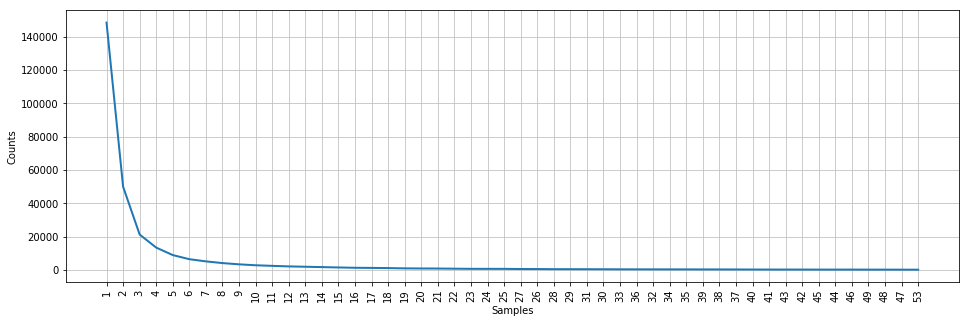

In [428]:
#freqdist = nltk.FreqDist([v for k,v in tokenset.items()])
#plt.figure(figsize=(16,5))
#freqdist.plot(50)

In [430]:
#print(sorted([(v,k) for k,v in tokenset.items()], reverse=True)[:50])

[(1676275, '.'), (332182, 'und'), (311909, 'die'), (273924, 'der'), (197524, 'ist'), (141949, 'nicht'), (140758, 'in'), (133773, 'Film'), (127979, 'zu'), (125849, 'den'), (118859, 'das'), (107551, 'ich'), (96049, 'mit'), (94922, 'ein'), (94156, 'von'), (93269, 'sich'), (92244, 'auch'), (85963, 'es'), (83960, 'auf'), (82682, 'man'), (71637, 'eine'), (65013, 'Die'), (64155, 'aber'), (63085, 'als'), (62585, 'für'), (61661, 'nur'), (59789, 'dem'), (58537, 'so'), (58348, 'hat'), (57079, 'wie'), (52200, 'im'), (51952, 'noch'), (50586, 'sind'), (48358, 'an'), (48076, 'wird'), (47696, 'DVD'), (47354, 'er'), (47307, 'dass'), (46712, 'des'), (45841, 'kann'), (41808, 'einen'), (41133, 'sehr'), (40283, 'Ich'), (39572, 'sie'), (37250, 'aus'), (36356, 'Der'), (35293, 'was'), (34892, 'war'), (34190, 'bei'), (33863, 'schon')]
